In [1]:
from connect_four.connect_four import ConnectFour, IllegalMove
from connect_four.agents import Agent, RandomAgent, MinMaxAgent, GPTAgent
from connect_four.arena import Arena
from connect_four.connect_four_dataset import (
    ConnectFourDataset, CharConnectFourDataset
)
from connect_four.data_processing_config import DatasetPreprocessingConfig
import pickle
import torch
import numpy as np
from mingpt.utils import sample
from mingpt.model import GPT, GPTConfig
from itertools import permutations
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.cuda.current_device()

In [2]:
def test_agents(first_agent: Agent, second_agent: Agent, n: int, swap_order=False):
    if swap_order:
        first_agent, second_agent = second_agent, first_agent
    # print(f"{first_agent.name} vs {second_agent.name}")
    results = [0, 0, 0]
    games = []
    illegal_moves = 0 
    for _ in range(n):
        game = ConnectFour()
        first_agent.set_game(game)
        second_agent.set_game(game)
        try:
            arena = Arena(first_agent, second_agent, game) 
            winner = arena.play()
            games.append(arena.game.history)
        except IllegalMove as illegal_move:
            # print(f"{illegal_move.value}, player id: {illegal_move.player_id}")
            illegal_moves += 1
            winner = 1 if illegal_move.player_id == 2 else 2
            if (
                (illegal_move.player_id == 1 and type(first_agent) != GPTAgent) or
                (illegal_move.player_id == 2 and type(second_agent) != GPTAgent)
            ):
                raise Exception("Bot made an illegal move")
        results[winner] += 1
    return {
        "results": results,
        "illegal_moves": illegal_moves,
        "games": games
    }

In [3]:
with open("connect_four/dataset/dataset_6x7_110000.pkl", "rb") as f:
    random_games = pickle.load(f)

random_cf_data = ConnectFourDataset(data_size=0, train_size=100000, games_to_use=random_games)
random_char_cf_dataset = CharConnectFourDataset(random_cf_data)

Dataset created has 100000 sequences, 8 unique words.


In [4]:
with open("connect_four/dataset/dataset_minmax_123_7383.pkl", "rb") as f:
    minmax_games = pickle.load(f)
minmax_cf_data = ConnectFourDataset(data_size=0, train_size=7138, games_to_use=minmax_games)
minmax_char_cf_dataset = CharConnectFourDataset(minmax_cf_data)

Dataset created has 7138 sequences, 8 unique words.


In [5]:
game = ConnectFour()
mconf = GPTConfig(
    random_char_cf_dataset.config.vocab_size, random_char_cf_dataset.config.block_size, n_layer=2, n_head=8, n_embd=80
)
model = GPT(mconf).to(device)
model.load_state_dict(torch.load("./ckpts/gpt_at_20230618_093325.ckpt"))
random_gpt_agent = GPTAgent(model, game, random_char_cf_dataset.config, name="Random GPT", device=device)

In [6]:
mconf = GPTConfig(
    minmax_char_cf_dataset.config.vocab_size, minmax_char_cf_dataset.config.block_size, n_layer=2, n_head=8, n_embd=80
)
model = GPT(mconf).to(device)
model.load_state_dict(torch.load("./ckpts/minmax_models/gpt_at_20230619_114002.ckpt"))
minmax_gpt_agent = GPTAgent(model, game, minmax_char_cf_dataset.config, first_move=4, name="MinMax GPT", device=device)

In [7]:
random_agent = RandomAgent(game, "RandomAgent")
minmax_one_agent = MinMaxAgent(game, max_depth=1, player_id=1, name="MinMax Depth 1")
minmax_two_agent = MinMaxAgent(game, max_depth=2, player_id=1, name="MinMax Depth 2")
minmax_three_agent = MinMaxAgent(game, max_depth=3, player_id=1, name="MinMax Depth 3")

In [8]:
def merge_results(results_one: list[int], results_two: list[int]) -> list[int]:
    """
    Used to merge results of the games between two agents.
    Parameters
    ----------
    results_one: list[int]
        Results of some matches
    results_two: list[int]
        Results of some matches, but in the different order than the results_one.
    """
    return [
        results_one[0] + results_two[0],
        results_one[1] + results_two[2],
        results_one[2] + results_two[1]
    ]

In [9]:
def get_num_of_wins(results: list[list[int]], pos: int) -> int:
    wins = []
    for result in results:
        wins.append(result[pos])
    return wins

In [10]:
def produce_wins(n: int, randomness_params: list[float], gpt_starts: bool = True):
    enemy_pawn = 2 if gpt_starts else 1
    gpt_pawn = 1 if gpt_starts else 2
    wins_vs_random, wins_vs_random_gpt, wins_vs_minmax1, wins_vs_minmax2, wins_vs_minmax3 = [], [], [], [], []
    draws_vs_random, draws_vs_random_gpt, draws_vs_minmax1, draws_vs_minmax2, draws_vs_minmax3 = [], [], [], [], []
    for randomness_param in tqdm(randomness_params):
        minmax_gpt_agent = GPTAgent(model, ConnectFour(), minmax_char_cf_dataset.config,
                                    first_move=4, name="MinMax GPT", device=device, randomness=randomness_param)
        results = test_agents(minmax_gpt_agent, random_agent, n=n, swap_order=not gpt_starts)
        wins_vs_random.append(results["results"][gpt_pawn])
        draws_vs_random.append(results["results"][0])

        results = test_agents(minmax_gpt_agent, random_gpt_agent, n=n, swap_order=not gpt_starts)
        wins_vs_random_gpt.append(results["results"][gpt_pawn])
        draws_vs_random_gpt.append(results["results"][0])

        minmax_one_agent.set_player_id(enemy_pawn)
        results = test_agents(minmax_gpt_agent, minmax_one_agent, n=n, swap_order=not gpt_starts)
        wins_vs_minmax1.append(results["results"][gpt_pawn])
        draws_vs_minmax1.append(results["results"][0])
        
        minmax_two_agent.set_player_id(enemy_pawn)
        results = test_agents(minmax_gpt_agent, minmax_two_agent, n=n, swap_order=not gpt_starts)
        wins_vs_minmax2.append(results["results"][gpt_pawn])
        draws_vs_minmax2.append(results["results"][0])

        minmax_three_agent.set_player_id(enemy_pawn)
        results = test_agents(minmax_gpt_agent, minmax_three_agent, n=n, swap_order=not gpt_starts)
        wins_vs_minmax3.append(results["results"][gpt_pawn])
        draws_vs_minmax3.append(results["results"][0])
    return (
        (wins_vs_random, wins_vs_random_gpt, wins_vs_minmax1, wins_vs_minmax2, wins_vs_minmax3),
        (draws_vs_random, draws_vs_random_gpt, draws_vs_minmax1, draws_vs_minmax2, draws_vs_minmax3)
    )
    

In [18]:
def plot_wins(
    x: list[float],
    vs_random: list[int],
    vs_random_gpt: list[int],
    vs_minmax_one: list[int],
    vs_minmax_two: list[int],
    vs_minmax_three: list[int],
    title: str,
    n: int
):
    plt.scatter(x, vs_random)
    plt.plot(x, vs_random, label="Random")

    plt.scatter(x, vs_random_gpt)
    plt.plot(x, vs_random_gpt, label="GPT trained on Random")

    plt.scatter(x, vs_minmax_one)
    plt.plot(x, vs_minmax_one, label="MinMax Depth 1")

    plt.scatter(x, vs_minmax_two)
    plt.plot(x, vs_minmax_two, label="MinMax Depth 2")

    plt.scatter(x, vs_minmax_three)
    plt.plot(x, vs_minmax_three, label="MinMax Depth 3")
    plt.title(title)
    plt.ylabel("Number of games")
    plt.xlabel("Randomness")
    plt.ylim(-0.5, n + 5)
    plt.legend(loc="upper right", bbox_to_anchor=(1.48, 1))
    plt.show()

In [14]:
n = 100
randomness_params = [0, 0.2, 0.4, 0.6, 0.8] 

In [15]:
wins_starts, draws_starts = produce_wins(gpt_starts=True, n=n, randomness_params=randomness_params)
wins_second, draws_second = produce_wins(gpt_starts=False, n=n, randomness_params=randomness_params)

100%|██████████| 5/5 [11:49<00:00, 141.83s/it]


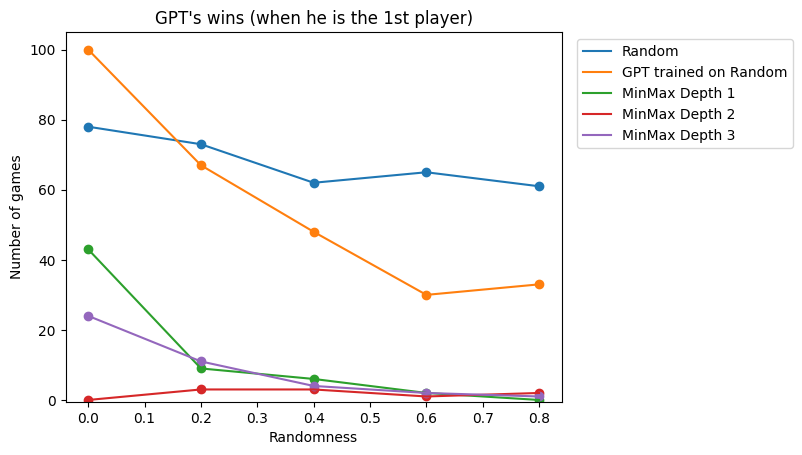

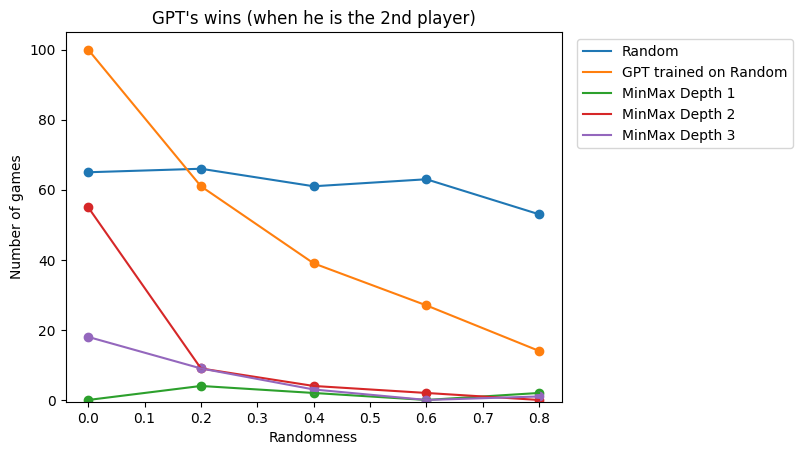

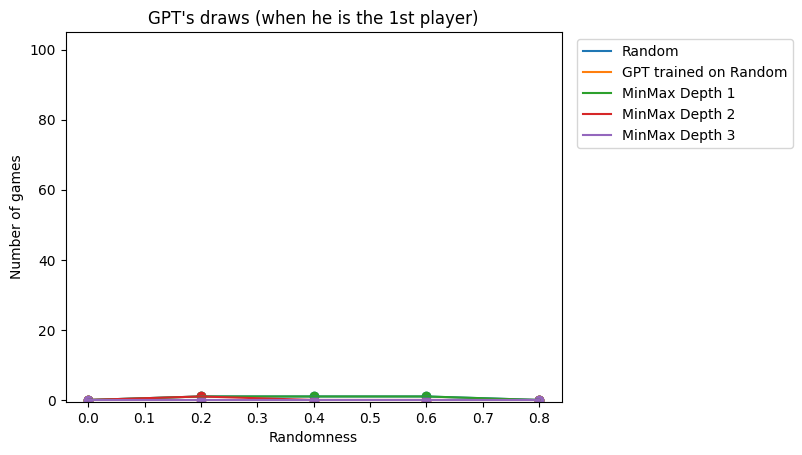

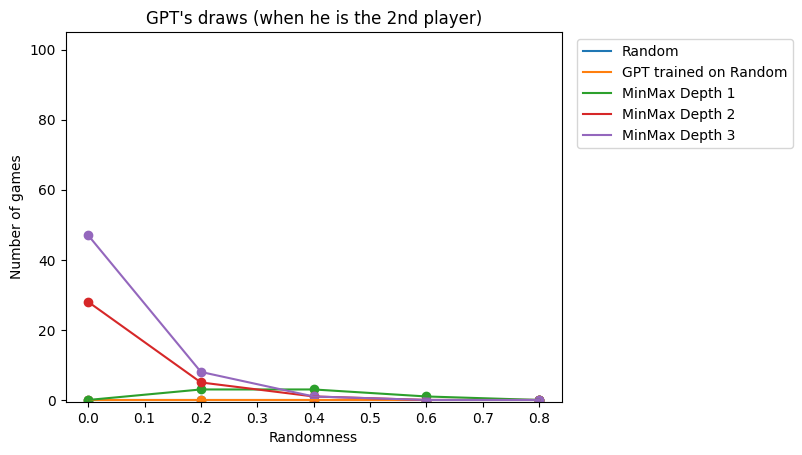

In [19]:
plot_wins(randomness_params, *wins_starts, 
          title="GPT's wins (when he is the 1st player)", n=100)
plot_wins(randomness_params, *wins_second, 
          title="GPT's wins (when he is the 2nd player)", n=100)
plot_wins(randomness_params, *draws_starts, 
          title="GPT's draws (when he is the 1st player)", n=100)
plot_wins(randomness_params, *draws_second, 
          title="GPT's draws (when he is the 2nd player)", n=100)